# MNIST Side Quests! Base Comparison

What does it look like if our sub losses are zeroed? We would expect this to match our main quest model.

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Globals

In [2]:
MODEL_NAME = "./temp-2.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

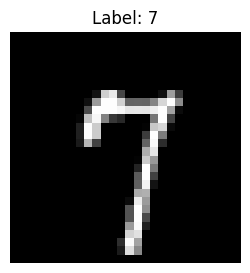

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [8]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

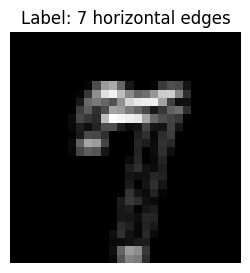

In [9]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [10]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [11]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [12]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

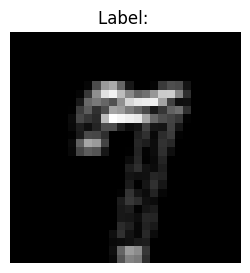

In [13]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [14]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [15]:
vertical_edges = get_edges(vertical_kernel, sample_image)

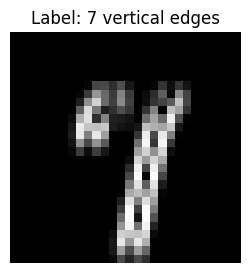

In [16]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [17]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [18]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [19]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

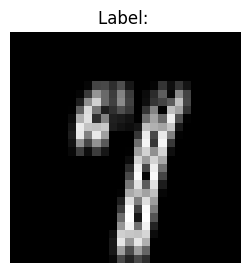

In [20]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # detached verision for vertical loss only
        # detached_input = horizontal_act.detach()
        # vertical_out_detached = self.vertical_layer(detached_input)
        # vertical_act_detached = self.activation_function(vertical_out_detached)

        # coupling layer
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [22]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()

# optimizers
horizontal_optimizer = torch.optim.Adam(model.horizontal_layer.parameters())
vertical_optimizer = torch.optim.Adam(model.vertical_layer.parameters())
classification_optimizer = torch.optim.Adam(model.classification_layer.parameters())

In [24]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [25]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [26]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
        )

In [27]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [28]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

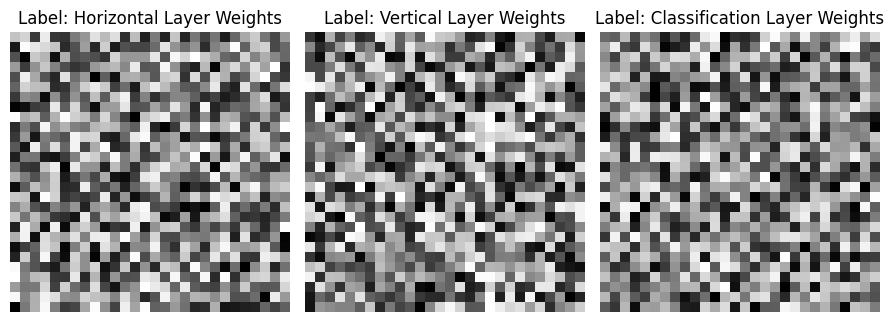

Epoch 1/20
  Train Loss: 0.7097
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.4605 | Val Acc: 89.87%


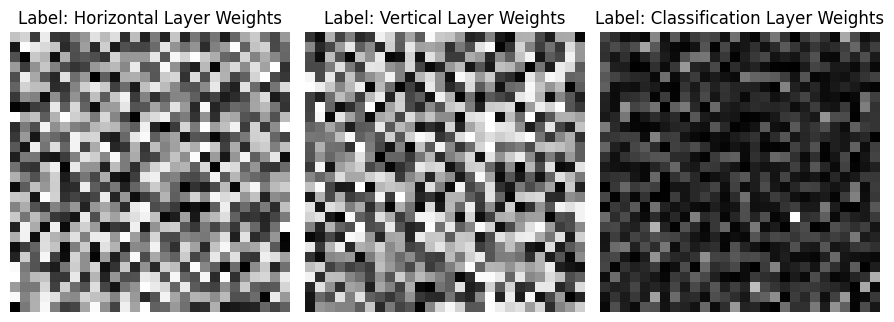

Epoch 2/20
  Train Loss: 0.3921
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.4056 | Val Acc: 91.81%


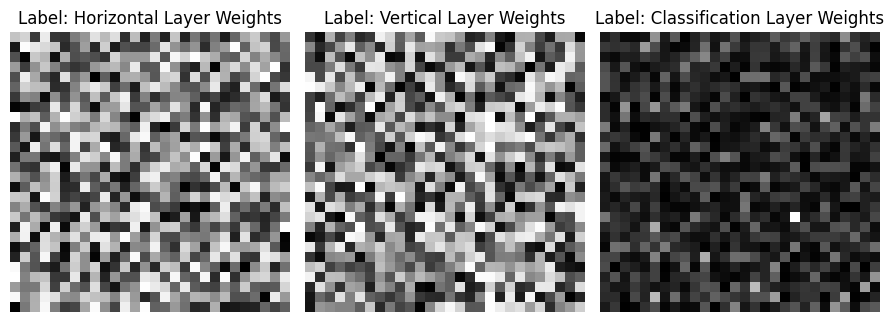

Epoch 3/20
  Train Loss: 0.3597
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.3621 | Val Acc: 92.92%


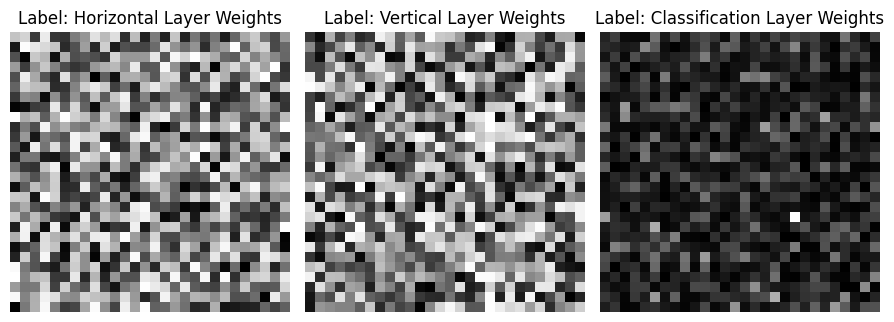

Epoch 4/20
  Train Loss: 0.3563
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.4306 | Val Acc: 92.33%


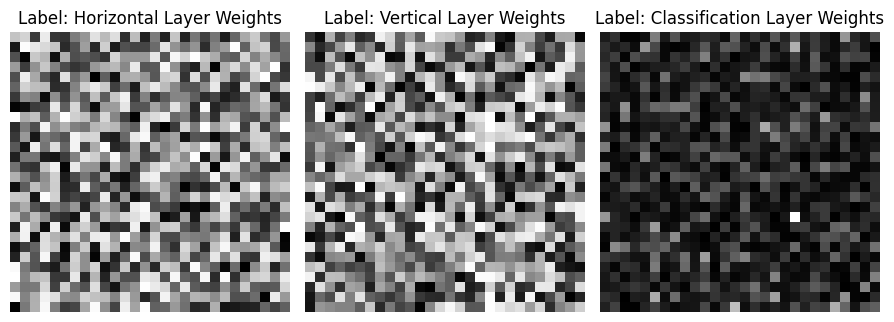

Epoch 5/20
  Train Loss: 0.3577
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5316 | Val Acc: 91.50%


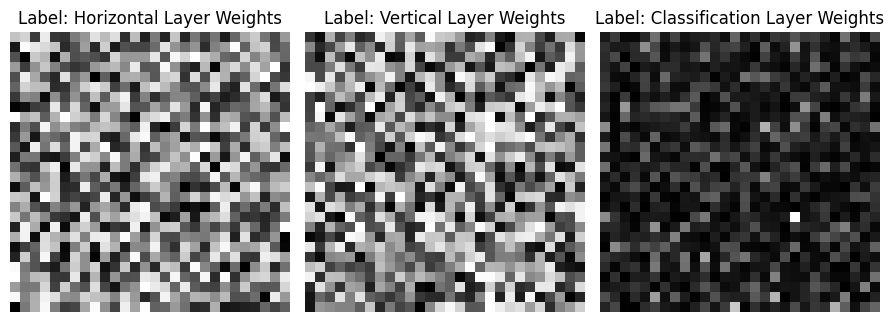

Epoch 6/20
  Train Loss: 0.3489
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.4279 | Val Acc: 92.93%


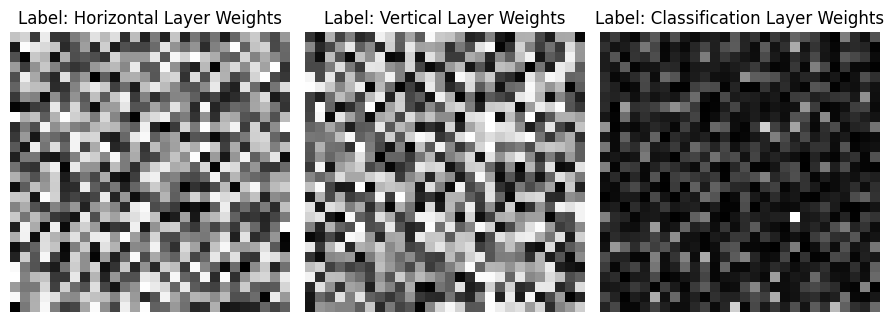

Epoch 7/20
  Train Loss: 0.3396
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5369 | Val Acc: 91.91%


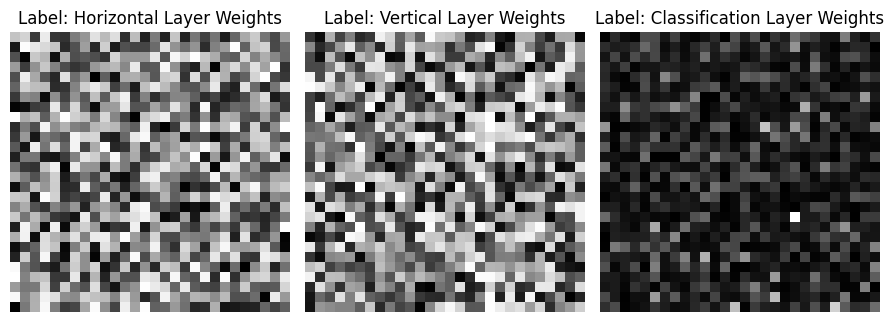

Epoch 8/20
  Train Loss: 0.3379
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5744 | Val Acc: 91.75%


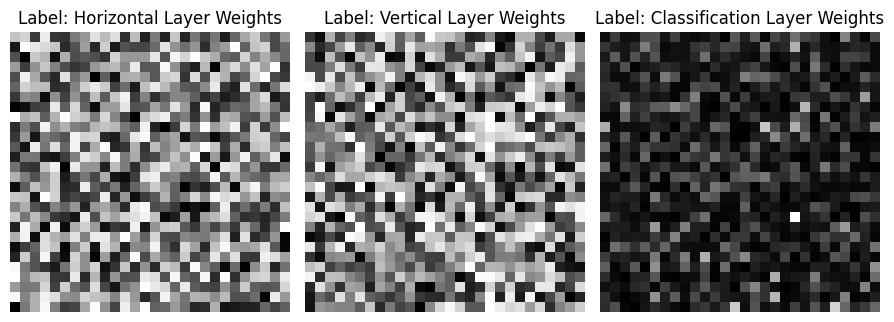

Epoch 9/20
  Train Loss: 0.3241
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5764 | Val Acc: 91.55%


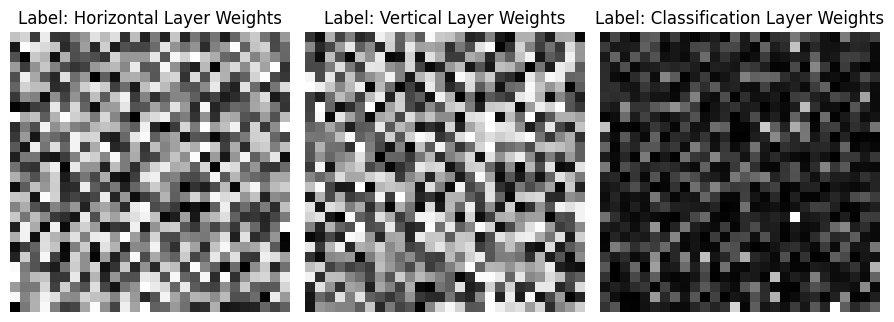

Epoch 10/20
  Train Loss: 0.3390
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.6435 | Val Acc: 91.78%


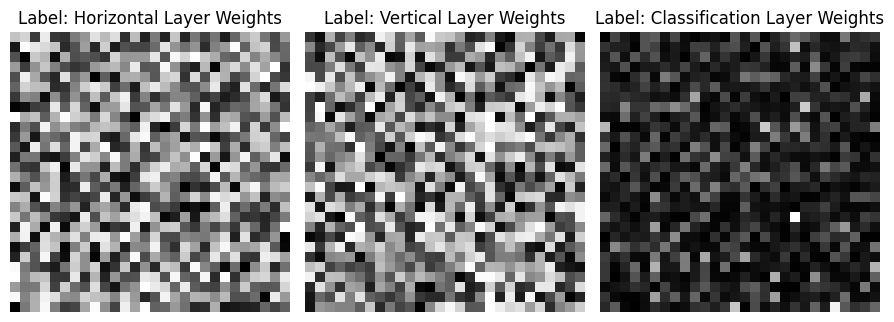

Epoch 11/20
  Train Loss: 0.3266
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5461 | Val Acc: 92.98%


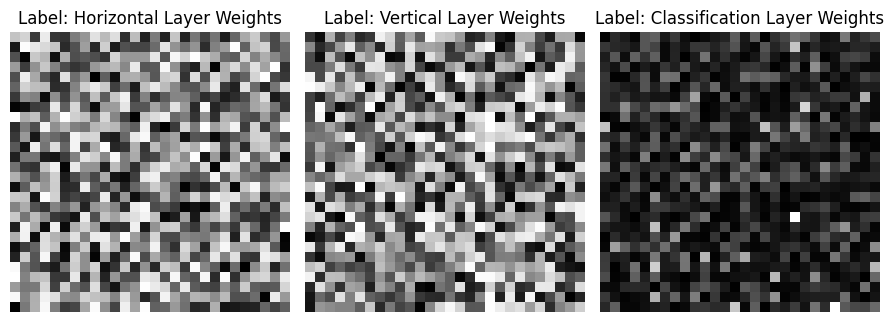

Epoch 12/20
  Train Loss: 0.3132
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5108 | Val Acc: 93.16%


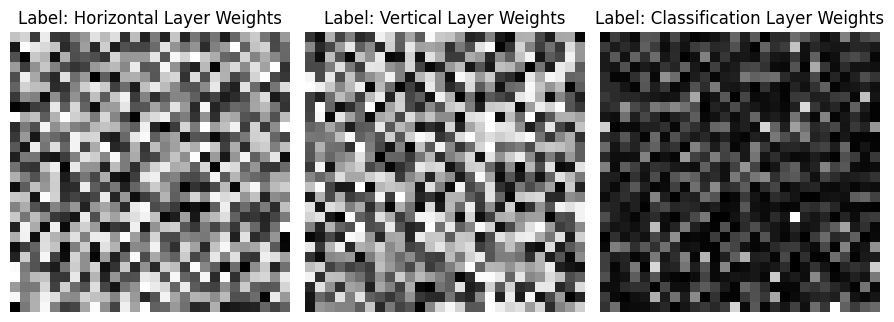

Epoch 13/20
  Train Loss: 0.2996
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.4682 | Val Acc: 93.84%


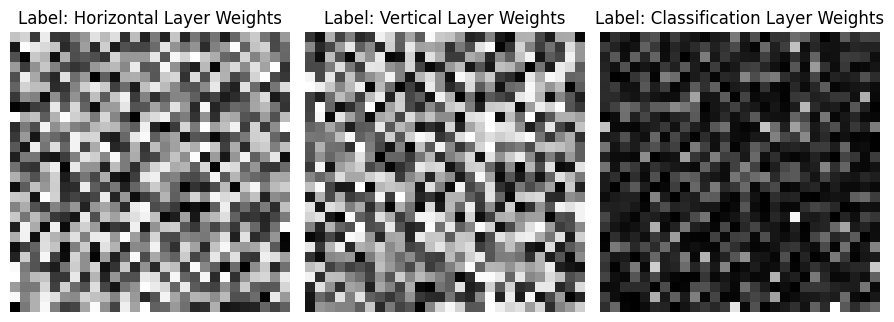

Epoch 14/20
  Train Loss: 0.3175
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.6015 | Val Acc: 92.59%


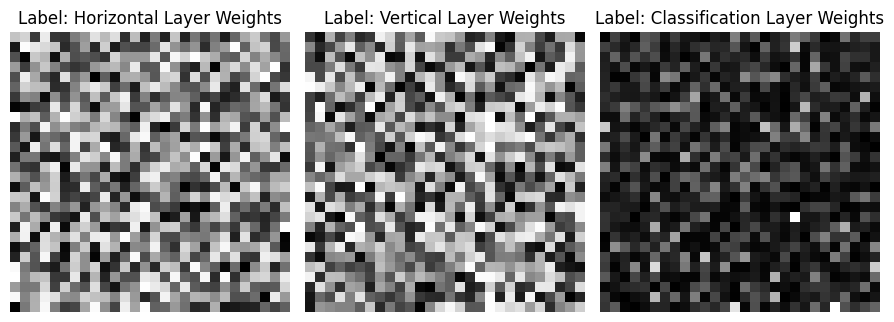

Epoch 15/20
  Train Loss: 0.3152
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.7352 | Val Acc: 90.98%


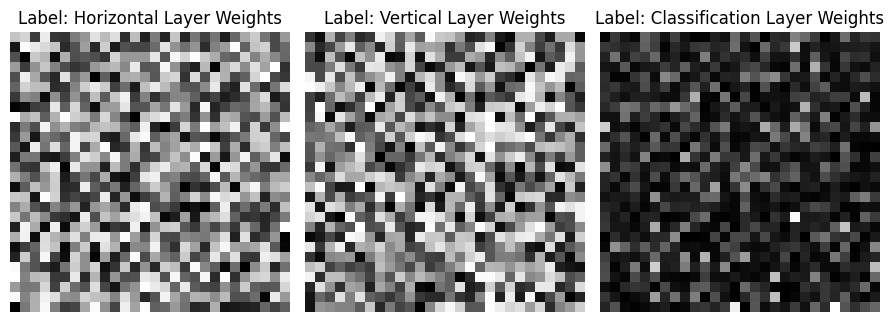

Epoch 16/20
  Train Loss: 0.3247
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.4943 | Val Acc: 93.94%


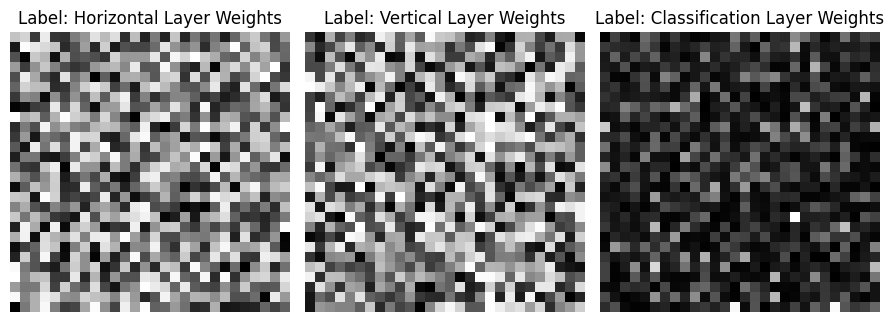

Epoch 17/20
  Train Loss: 0.3067
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.6391 | Val Acc: 92.88%


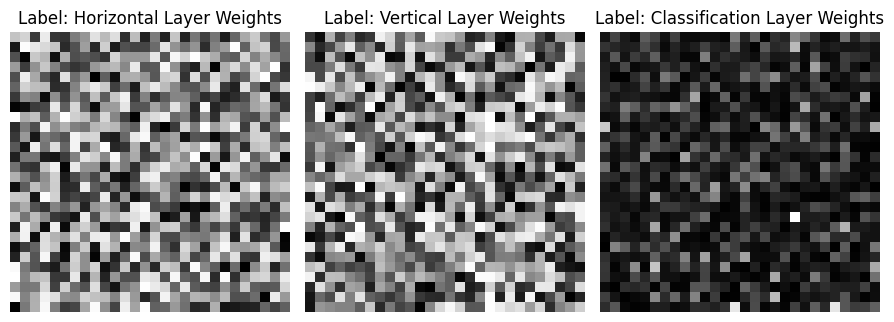

Epoch 18/20
  Train Loss: 0.2953
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.6177 | Val Acc: 92.84%


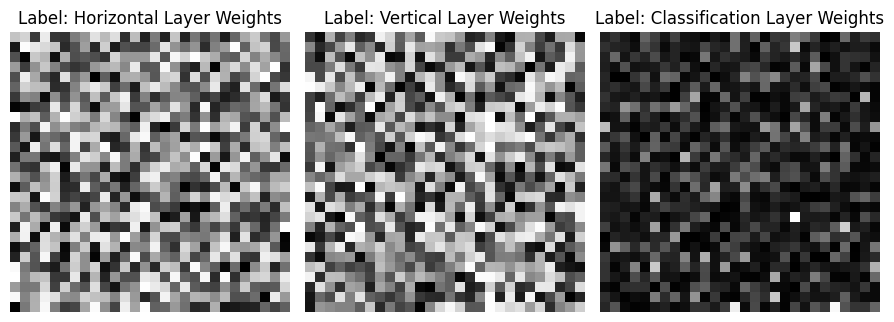

Epoch 19/20
  Train Loss: 0.3094
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.6784 | Val Acc: 92.67%


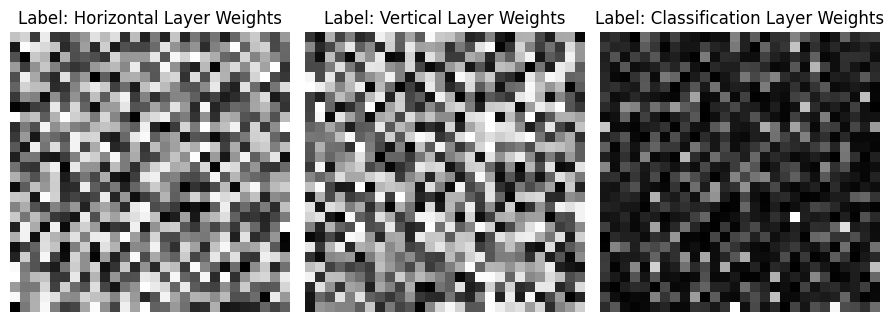

Epoch 20/20
  Train Loss: 0.3025
  Horizontal Edge Loss: 0.0000
  Vertical Edge Loss: 0.0000
  Val Loss: 0.5769 | Val Acc: 93.73%


In [29]:
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0
    horizontal_loss = 0.0
    vertical_loss = 0.0

    # visualizing weights at each epoch
    classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
    visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
    visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        side_quest_attention = 0

        # global update from the classification result
        classification_optimizer.zero_grad()
        classification_loss = classification_loss_fn(classification_out, labels)
        classification_loss.backward(retain_graph=True)
        classification_optimizer.step()
        
        # horizontal update
        horizontal_optimizer.zero_grad()
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels) * side_quest_attention
        horizontal_loss.backward(retain_graph=True)
        horizontal_optimizer.step()

        # vertical update
        vertical_optimizer.zero_grad()
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels) * side_quest_attention
        vertical_loss.backward()
        for name, param in model.named_parameters():
            if "vertical_layer" not in name:
                param.grad = None
        vertical_optimizer.step()

        # update progress
        train_loss += classification_loss.item()
        horizontal_loss += horizontal_loss.item()
        vertical_loss += vertical_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_horizontal_loss = horizontal_loss / len(train_loader)
    avg_vertical_loss = vertical_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Horizontal Edge Loss: {avg_horizontal_loss:.4f}")
    print(f"  Vertical Edge Loss: {avg_vertical_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_NAME)

## Eval

In [30]:
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 384.44it/s]

Final Test Accuracy: 93.28%


Interestingly enough, we don't seem to match the main quest. I wonder if zero's the loss still causes a small step in each of the unique optimizers... but this is strange...

# Exploring the Resulting Model

In [31]:
print(model.horizontal_layer.weight[0].shape)
print(model.horizontal_layer.bias.shape)

torch.Size([784])
torch.Size([784])


In [32]:
horizontal_layer_weights = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

## Visualizing Weights

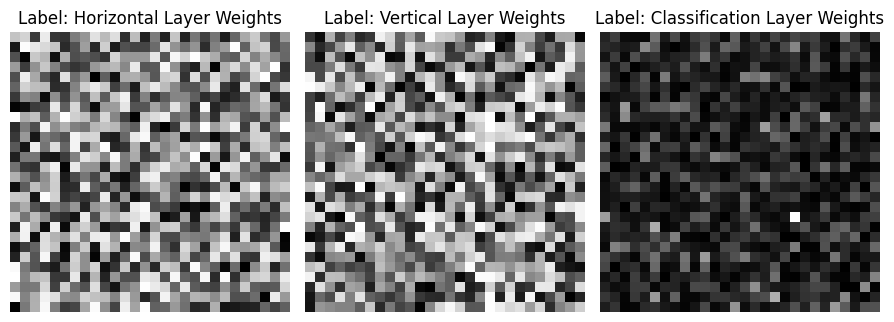

In [33]:
classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

fig, axes = plt.subplots(1, 3, figsize=(9, 5))

visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])

plt.tight_layout()
plt.show()

# Visualize Activations

In [34]:
model.eval()
eval_examples = list()
with torch.no_grad():
    for idx, img in enumerate(test_images[:10]):
        img_tensor = torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        eval_examples.append((label, img, out, v_act_img, h_act_img))

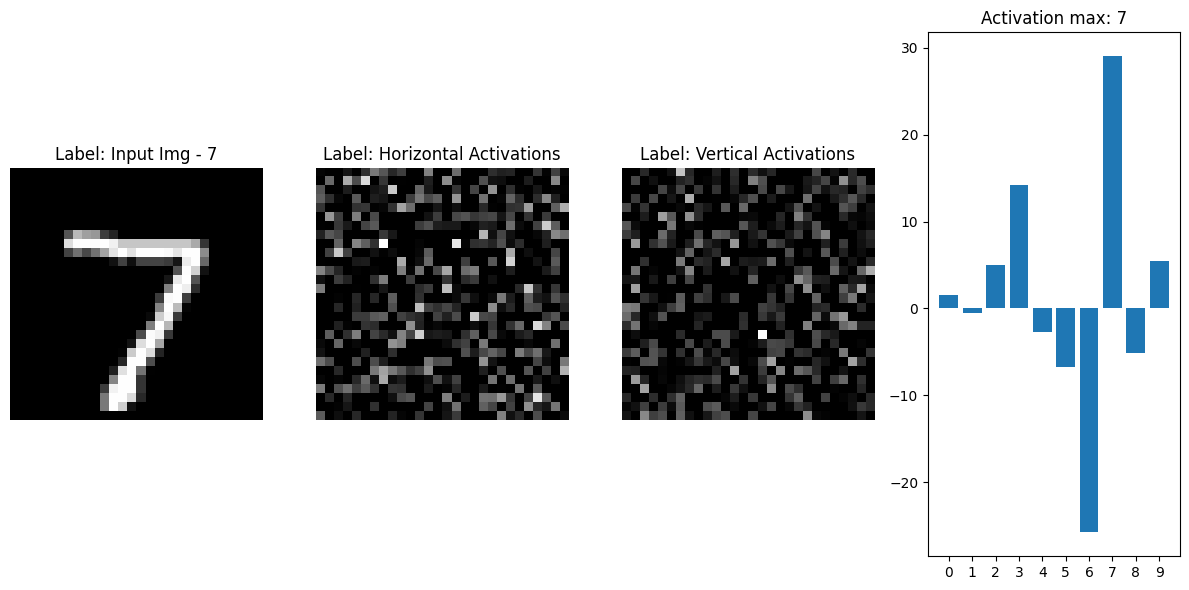

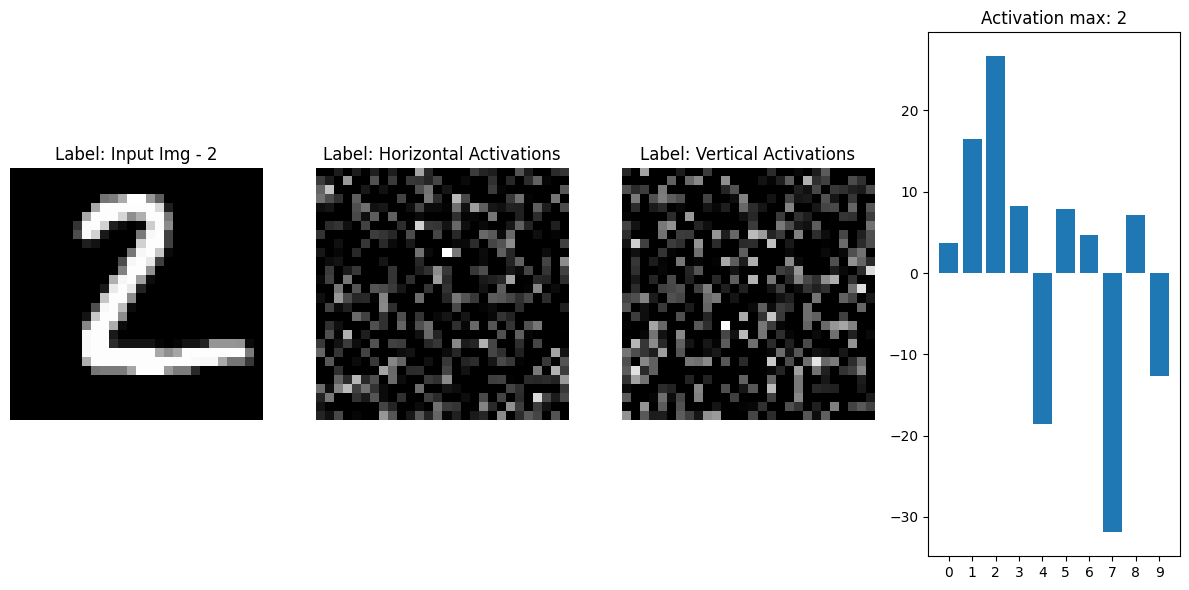

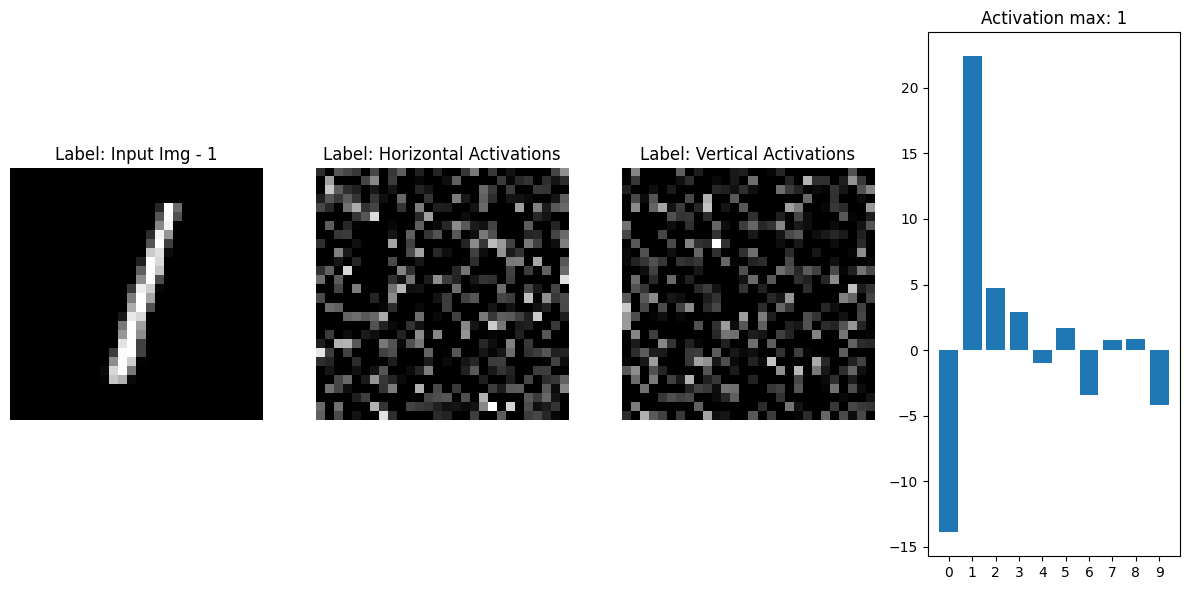

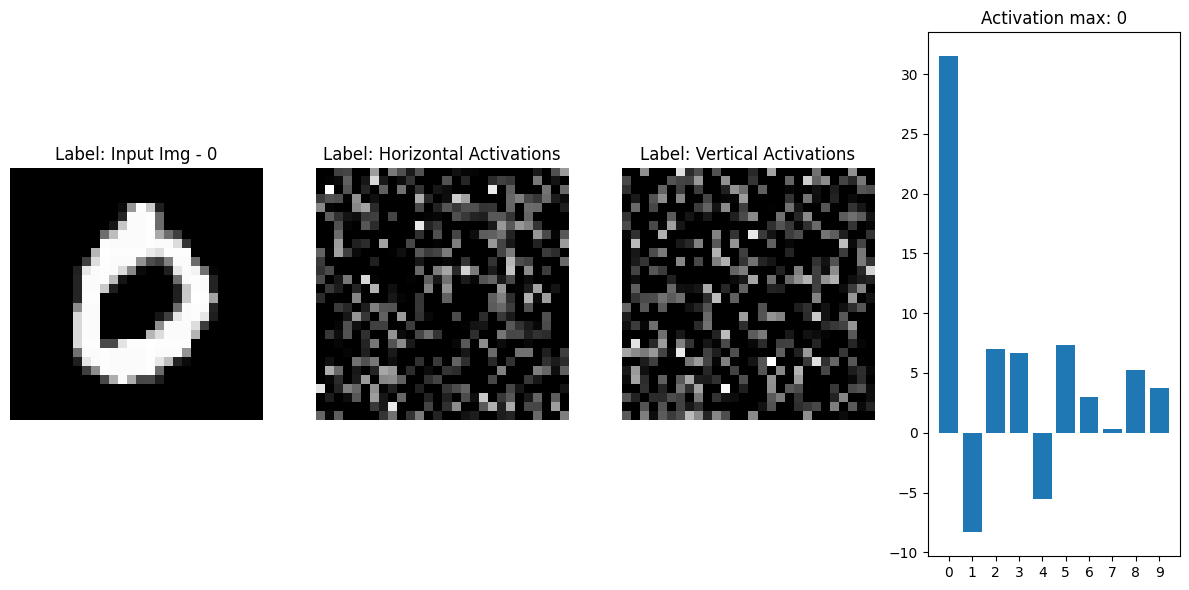

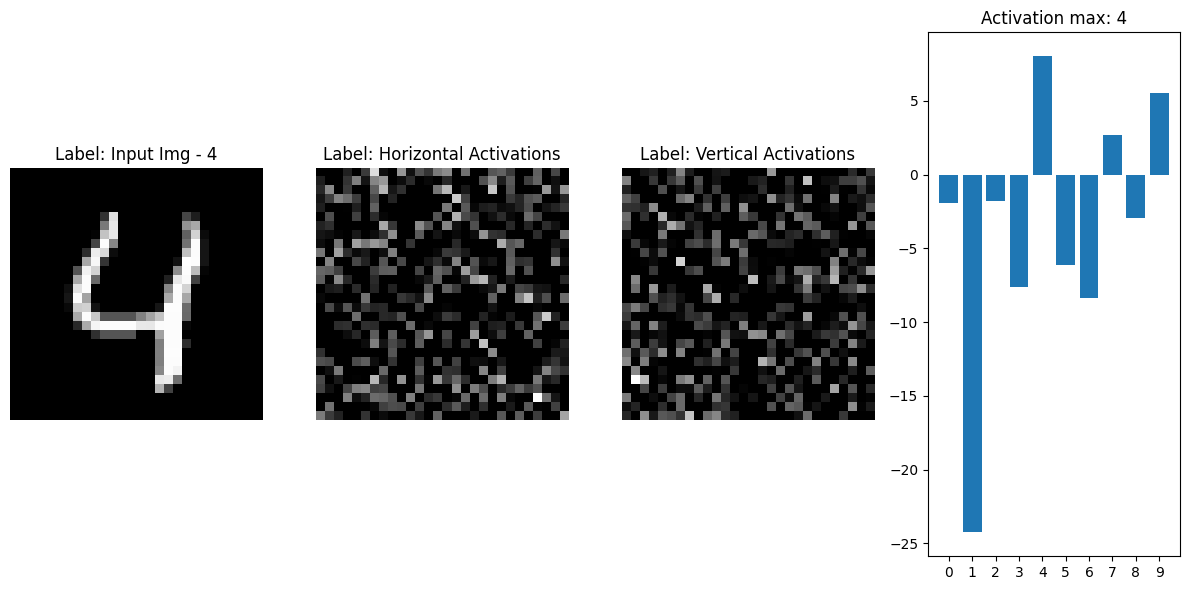

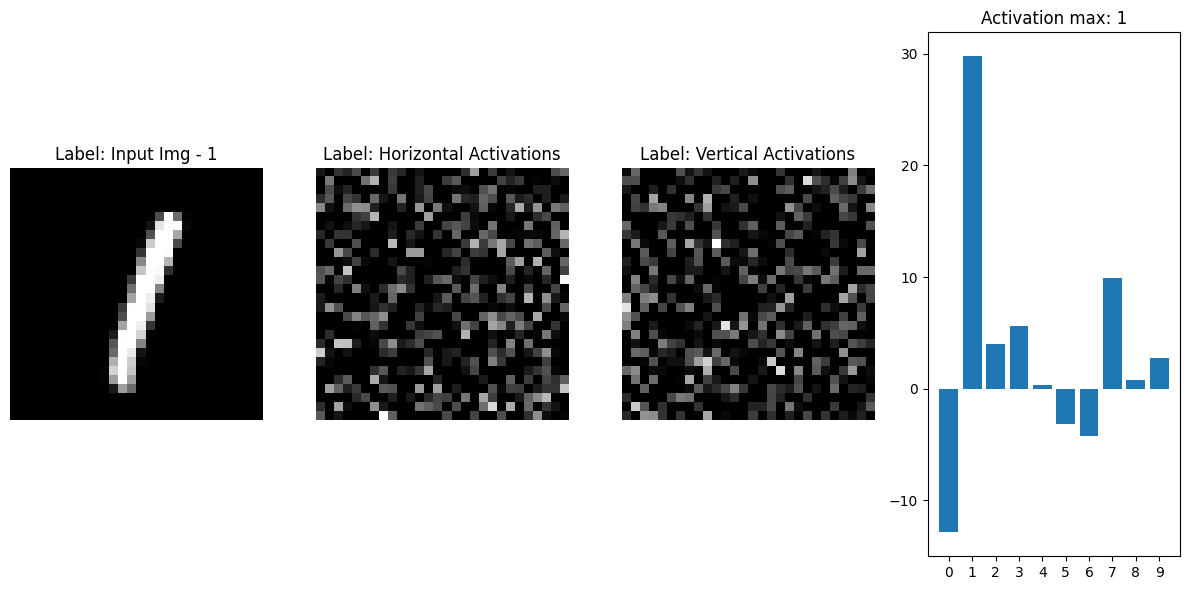

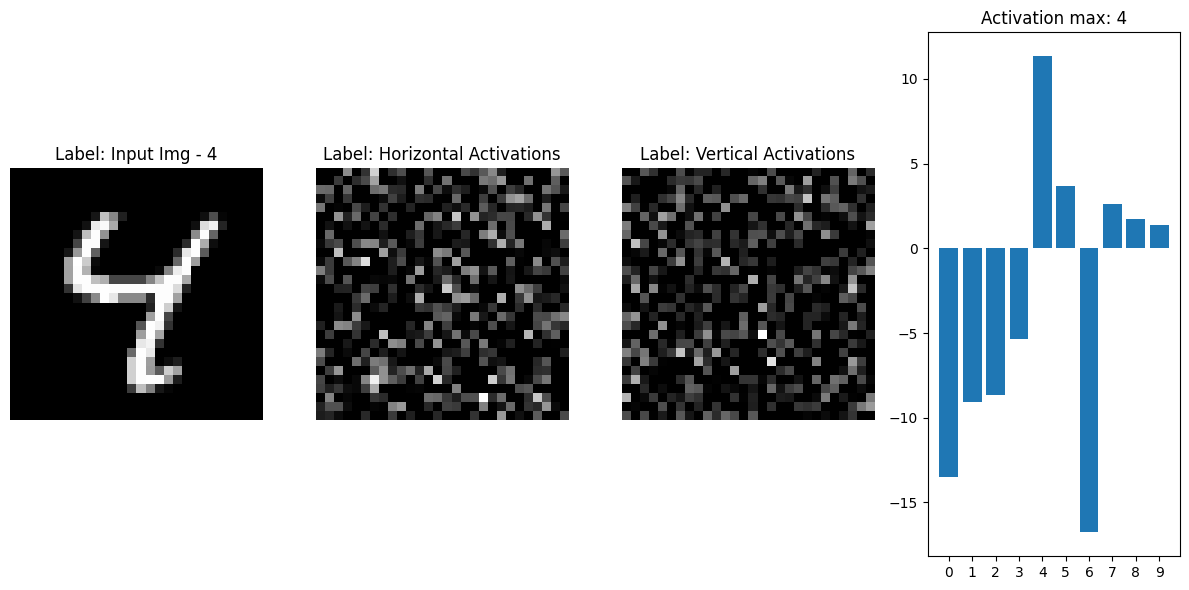

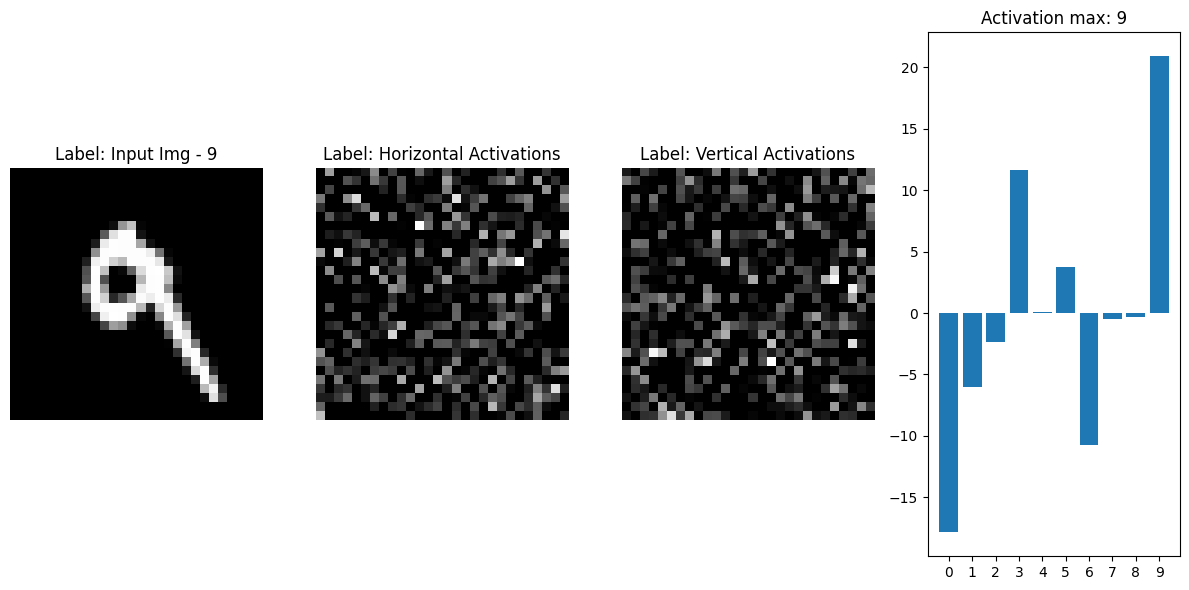

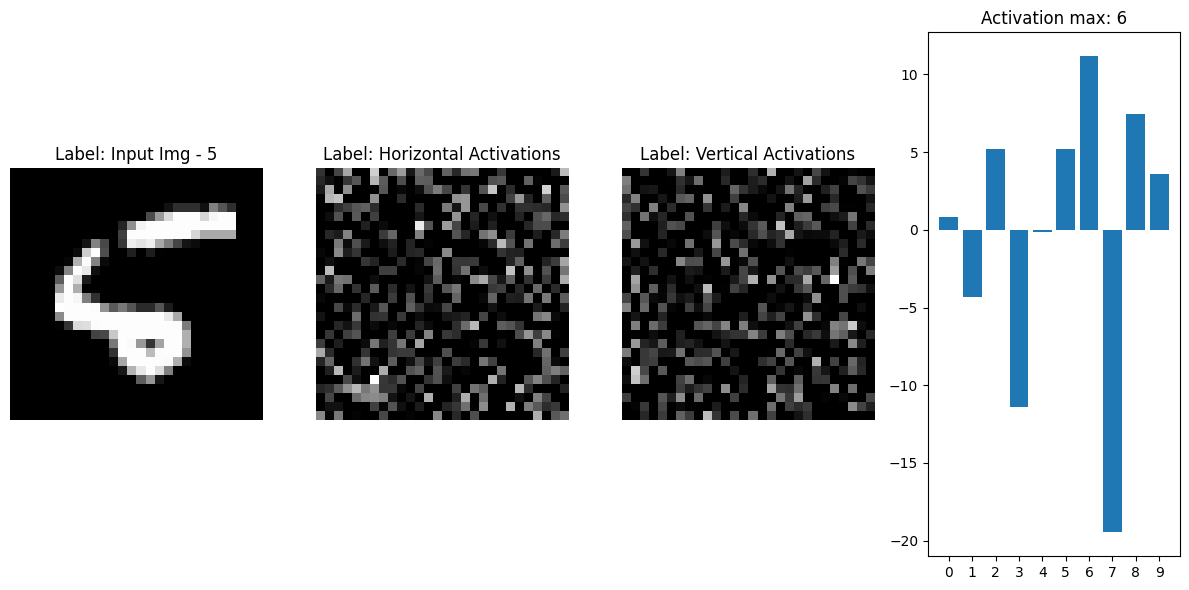

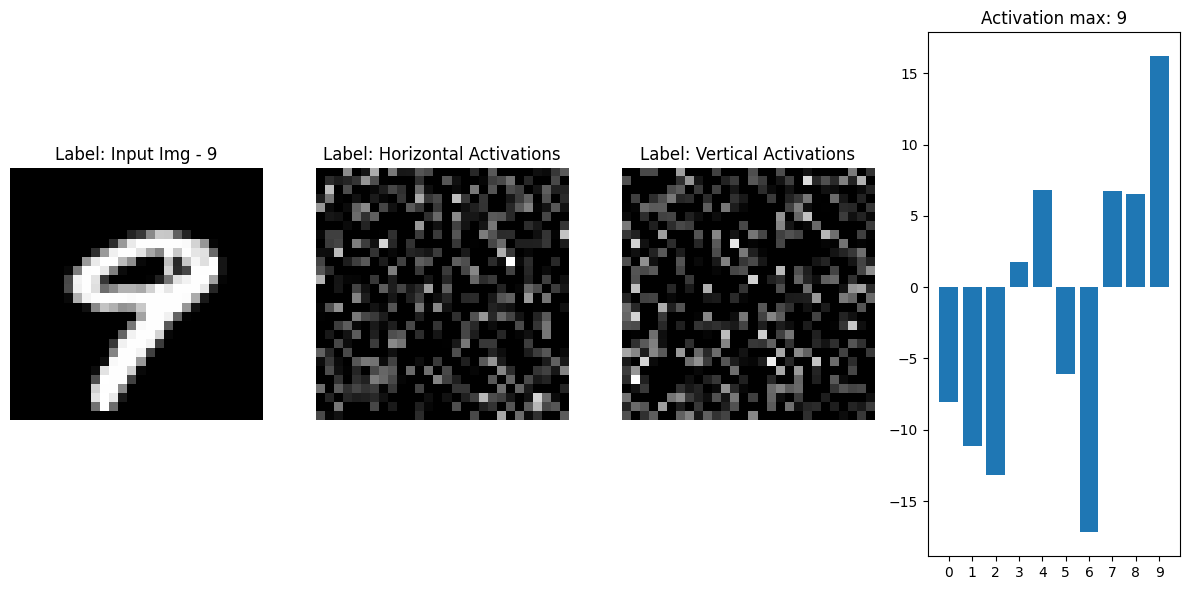

In [35]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in eval_examples:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()